### Imports

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from photonpairlab.spdc.simulation import SPDC_Simulation
from photonpairlab.spdc import SPDC_Analyzer
from photonpairlab.spdc import SPDC_Plotter
from photonpairlab.spdc.utils import linear, linear_fit, linear_intersection_coordinates
from photonpairlab.crystal import Crystal
from photonpairlab.laser import Laser
from photonpairlab.materials import KTP1, KTP2, KTP3

## Minimal example

### Preparing and running simulation

In [40]:
# Initialize crystal parameters
Lc = 46.175e-6                # Coherence length (in meters)
Lo = 30e-3                    # Crystal length (in meters)
T = 22.15                    # Temperature (in degrees Celsius)
w = 18e-6                     # Domain width parameter (in meters)

material = KTP1()
crystal = Crystal(Lc, Lo, T, w, material, spdc="type-II")

# Initialize laser parameters
lambda_2w = 780e-9            # Central wavelength of the pump (in meters)
pulse_duration = 1.7e-12      # Pulse duration (in seconds)
laser = Laser(lambda_2w, pulse_duration)

# Generate the poling pattern in the crystal
crystal.generate_poling(laser=laser, mode='periodic', resolution=5)

# Create and run the simulation
simulation = SPDC_Simulation(crystal, laser)
results = simulation.run_simulation(steps=50, dev=5)

### Access and plot results 

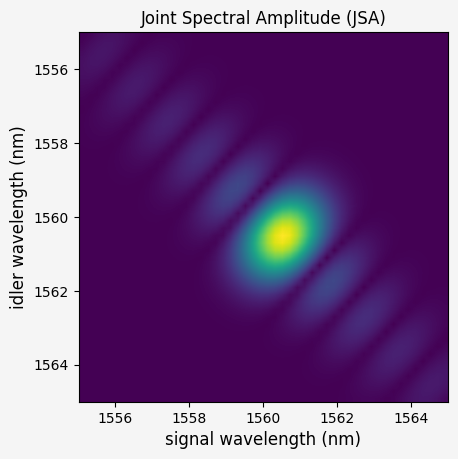

In [41]:
# Plot the results
plotter = SPDC_Plotter(results)
fig, ax = plotter.plot_jsa()

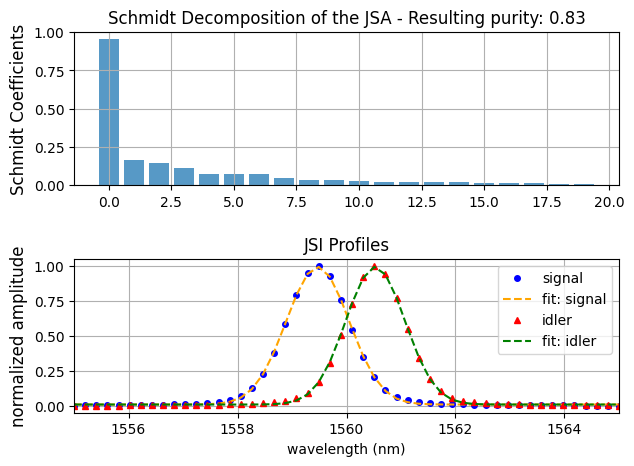

In [42]:
# Plot the results
plotter = SPDC_Plotter(results)
fig, ax = plotter.plot_schmidt_coefficients()

## Example: Find the optimal crystal temperature for a specific poling

### Preparing and running simulations

In [43]:
# Initialize crystal parameters
Lc = 46.1e-6                # Coherence length (in meters)
Lo = 30e-3                    # Crystal length (in meters)
w = 18e-6                     # Domain width parameter (in meters)

material = KTP1()

# Initialize laser parameters
lambda_2w = 780e-9            # Central wavelength of the pump (in meters)
pulse_duration = 1.7e-12      # Pulse duration (in seconds)
laser = Laser(lambda_2w, pulse_duration)

# Define a range of temperatures and create crystals for each temperature
temperatures = np.linspace(25, 35, 25)
crystals = [Crystal(Lc, Lo, temperature, w, material, spdc="type-II") for temperature in temperatures]

# Generate the poling pattern in the crystal
for crystal in crystals:
    crystal.generate_poling(laser=laser, mode='periodic', resolution=5)

# Create and run the simulations
simulations = [SPDC_Simulation(crystal, laser) for crystal in crystals]
results_list = [simulation.run_simulation(steps=50, dev=5) for simulation in simulations]

### Analysis of results

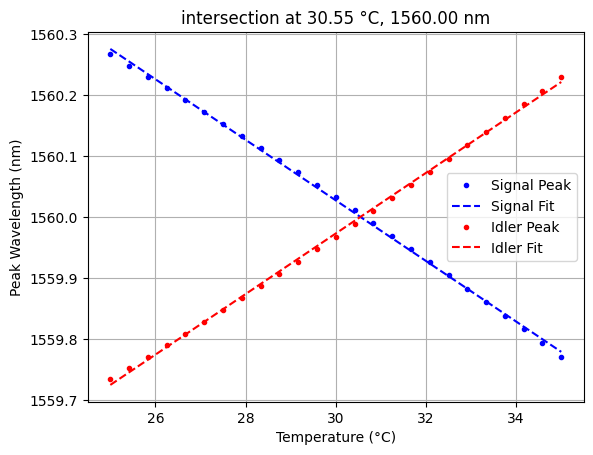

In [44]:
# Analyze the results to get signal and idler peaks
signal_peaks = []
idler_peaks = []

for results in results_list:
    analyzer = SPDC_Analyzer(results)
    signal_fit, idler_fit, _, _ = analyzer.get_signal_idler_fits()
    signal_peaks.append(signal_fit[1])  # Extract the center of the signal peak
    idler_peaks.append(idler_fit[1])    # Extract the center of the idler peak

# Convert peaks to numpy arrays for plotting
signal_peaks = np.array(signal_peaks)
idler_peaks = np.array(idler_peaks)

# Perform a linear fit to the peaks
popt_signal, _ = linear_fit(temperatures, signal_peaks)
popt_idler, _ = linear_fit(temperatures, idler_peaks)
x_intersect, y_intersect = linear_intersection_coordinates(*popt_signal, *popt_idler)

# Plot the results
fig, ax = plt.subplots()
ax.plot(temperatures, signal_peaks, marker='.', linestyle='None', color='blue', label='Signal Peak')
ax.plot(temperatures, linear(temperatures, *popt_signal), color='blue', linestyle='--', label='Signal Fit')
ax.plot(temperatures, idler_peaks, marker='.', linestyle='None', color='red', label='Idler Peak')
ax.plot(temperatures, linear(temperatures, *popt_idler), color='red', linestyle='--', label='Idler Fit')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Peak Wavelength (nm)')
ax.set_title(f"intersection at {x_intersect:.2f} °C, {y_intersect:.2f} nm")
ax.legend()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.grid()
plt.show()